In [1]:
# Importing modules

import socks
import socket
import requests
import codecs
from bs4 import BeautifulSoup

## Data Extraction from HTML

In [18]:
file = codecs.open("../raw-html/lockbit.html", "r", "utf-8")
  
# Reading the file
index = file.read()
  
# Creating a BeautifulSoup object and specifying the parser
soup = BeautifulSoup(index, 'lxml')

<body class="page">
 <div id="preloader_global" style="position: fixed; top: 0px; left: 0px; width: 100%; height: 100%; background: white; z-index: 100; display: none;">
  <style type="text/css">
   .preloader_global {
        display: none;
        background:#FBFBFB url( "");
        background-repeat:  no-repeat;
        background-position: center;
        z-index: 100;
    }
  </style>
  <div class="preloader_global">
   <div class="loader">
    <svg class="loader-pentagon" height="38px" viewbox="0 0 30 30" width="38px">
     <path d="M15.1566 27.5713C8.3214 27.5713 2.74176 21.9861 2.74176 15.1565C2.74176 8.32134 8.32704 2.7417 15.1566 2.7417C21.9918 2.7417 27.5713 8.32698 27.5713 15.1565C27.5713 21.9917 21.9918 27.5713 15.1566 27.5713Z" fill="url(#paint0_linear_221_3)">
     </path>
     <path d="M15 30C6.75 30 0 23.25 0 15C0 6.75 6.75 0 15 0C23.25 0 30 6.75 30 15C30 23.25 23.25 30 15 30ZM15 3.33528C8.58528 3.33528 3.33528 8.58528 3.33528 15C3.33528 21.4147 8.58528 26.6647 15 26.
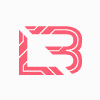

In [19]:
# Printing html code of body tag
print(soup.body.prettify())

## Data Cleaning

In [20]:
# Obtaining all posts
ransomware_posts = soup.find_all("div", {"class": "post-block bad"})
print(ransomware_posts)

[<div class="post-block bad" onclick="return go('/post/15WIYKgTiyZXHFij632b28b0d4b47'); ">
<div class="post-head">
<div class="post-top-block">
<div class="post-title-block">
<div class="post-title">
                                    parrottsims.com                                </div>
<div style="display: flex; justify-content: center; flex-wrap: wrap;">
<div class="post-timer" style="width:100%">
<div class="timer" data-timer="12"><span class="days">2D</span> <span class="hours">08h</span> <span class="minutes">46m</span> <span class="seconds">45s</span> </div>
</div>
</div>
<div class="post-timer-end d-none">
                                    published
                                </div>
</div>
</div>
</div>
<div class="post-block-body">
<div class="post-block-text">
                            
                            We are a full-service law firm providing our clients with superior legal services by leveraging our resources and personnel to deliver timely legal advice

### Titles

In [26]:
post_titles_tag = soup.find_all("div", {"class": "post-title"})
post_titles = [tag.text.strip() for tag in post_titles_tag]
print(post_titles)

['parrottsims.com', 'rbroof.com', 'ch-sf.fr', 'congerbuilt.com', 'thorguard.com', 'scrd.ca', 'franckbeun.fr', 'idtech.com.tw', 'webnordeste.com.br', 'psi.com.tw', 'yourprivateitaly.com', 'software-line.it', 'ducanh.com', 'uide.edu.ec', 'marugokiso.co.jp', 'ifwglobal.com', 'elementnor.no', 'mts.mektec.com', 'okibrasil.com', 'hering-heinz.de', 'First bounty payout $50,000', 'dss-cz.com', 'ces-conditionneur.fr', 'kaffeeberlin.com', 'scottobrothers.com', 'equatortrustees.com', 'orioninc.com', 'nakamuracorp.co.jp', 'aliat.group', 'd-securite.com', 'medical69.com', 'asecna.org', 'markherder.com', 'southamptoncounty.org', 'cnachile.cl', 'independence.com.co', 'makler.com.ve', 'inspecshawaii.com', 'kcgreenholdings.com', 'aipcenergy.com', 'cityofbartlett.org', 'quintal.com.co', 'ville-faulquemont.fr', 'sva-avignon.concession-landrover.fr', 'sarassure.fr', 'pays-colombey-sudtoulois.fr', 'mj-donnais.fr', 'maleosante.fr', 'maisonloisy.fr', 'lagence33.com', 'jt-engineering.com', 'euromip.fr', 'euro

### Descriptions

In [36]:
post_desc_tag = soup.find_all("div", {"class": "post-block-text"})
post_desc = [tag.text.strip() for tag in post_desc_tag]
post_desc = [desc.replace('\r\n', ' ').replace('\r\n\r', ' ') for desc in post_desc]
print(post_desc)

['We are a full-service law firm providing our clients with superior legal services by leveraging our resources and personnel to deliver timely legal advice...  Phone: +1 832-485-6000', "Phone Number: (888) 260-3947  Owners phone numbers:  Doug Reader (214) 221-5000 ext 221  Kevin Ballard (214) 221-5000 ext 222  But external not working...  CEOs completely ignored our calls and said they didn't care about anything.  Fo...", 'We present to you the French clinic. CH-SF.FR REVENUE $650 million. This company does not want to fulfill its part of the transaction to buy out the decryptor and personal data of its customers, patients and partners. This company does not care a...', 'When Larry Conger founded Conger Construction Group in 1992, he had a vision of building a company that would act with integrity in every project, no matter what the challenge. Since then, we’ve established ourselves as one of the most respected cons...', 'THOR GUARD began manufacturing Lightning Prediction Systems i

### Dates

In [42]:
post_date_tag = soup.find_all("div", {"class": "updated-post-date"})
post_date = [tag.text.strip() for tag in post_date_tag]
post_date = [tag.replace('\xa0\xa0', '').replace('Updated: ', '') for tag in post_date]
print(post_date)

['24 Sep, 2022, 00:03 UTC', '23 Sep, 2022, 15:21 UTC', '23 Sep, 2022, 12:19 UTC', '22 Sep, 2022, 23:20 UTC', '22 Sep, 2022, 23:05 UTC', '22 Sep, 2022, 23:04 UTC', '22 Sep, 2022, 22:09 UTC', '22 Sep, 2022, 18:07 UTC', '22 Sep, 2022, 10:45 UTC', '21 Sep, 2022, 22:57 UTC', '21 Sep, 2022, 22:52 UTC', '21 Sep, 2022, 22:47 UTC', '21 Sep, 2022, 22:39 UTC', '21 Sep, 2022, 22:37 UTC', '21 Sep, 2022, 22:03 UTC', '21 Sep, 2022, 11:31 UTC', '20 Sep, 2022, 08:08 UTC', '19 Sep, 2022, 20:46 UTC', '19 Sep, 2022, 20:13 UTC', '19 Sep, 2022, 09:25 UTC', '17 Sep, 2022, 02:39 UTC', '16 Sep, 2022, 03:46 UTC', '16 Sep, 2022, 03:25 UTC', '16 Sep, 2022, 03:23 UTC', '16 Sep, 2022, 03:17 UTC', '16 Sep, 2022, 03:16 UTC', '15 Sep, 2022, 16:47 UTC', '15 Sep, 2022, 09:53 UTC', '14 Sep, 2022, 22:12 UTC', '14 Sep, 2022, 22:08 UTC', '14 Sep, 2022, 22:06 UTC', '14 Sep, 2022, 20:38 UTC', '14 Sep, 2022, 20:25 UTC', '14 Sep, 2022, 20:15 UTC', '14 Sep, 2022, 20:09 UTC', '14 Sep, 2022, 19:32 UTC', '14 Sep, 2022, 19:13 UTC', 

### Views

In [43]:
post_views_tag = soup.find_all("span", {"style": "font-size: 12px; font-weight: bold"})
post_views = [tag.text.strip() for tag in post_views_tag]
print(post_views)

['346', '243', '2134', '263', '274', '365', '698', '250', '278', '665', '352', '1467', '644', '357', '2577', '423', '543', '706', '730', '799', '1736', '1727', '1326', '1308', '1297', '1291', '2816', '1696', '1655', '1686', '1668', '1359', '1730', '1655', '1662', '1668', '1651', '1842', '1814', '1816', '1834', '1797', '1815', '1805', '1775', '1761', '1741', '1752', '1739', '1734', '1737', '1728', '1730', '1704', '1728', '1696', '1777', '1806', '1728', '1700', '1660', '1642', '1666', '1690', '1886', '3435', '5211', '4877', '5056', '7581', '6838', '8142', '3436', '4962', '6081', '2124', '8760', '7562', '3149', '6440', '6949', '5384', '8161', '2510', '4765', '7624', '7531', '2501', '7730', '6507', '4807', '4834', '8129', '5955', '7694', '7503', '6420', '3502', '5042', '5116', '2506', '7597', '6057', '7782', '1562', '1689', '7851', '6824', '7856', '4028', '3545', '8104', '5099', '4781', '3016', '7457', '7715', '6813', '4654', '12347', '7218', '6565', '7831', '4968', '7680', '7617', '5056',

In [45]:
# Verify all are extracted
print(len(post_titles) == len(post_desc) == len(post_date) == len(post_views))

True


In [66]:
import pandas as pd
import numpy as np

df = pd.DataFrame(columns=['Company Name', 'Location', 'Industry', 'Post Title', 'Description', 'Post Date', 'Post Views'])
df['Post Title'] = post_titles
df['Description'] = post_desc
df['Post Date'] = post_date
df['Post Views'] = post_views

df
df.to_csv('Lockbit2.csv')

In [5]:
import pandas as pd

df = pd.read_csv('../csv-data/Lockbit2.csv')
df.head()

,Unnamed: 0,Company Name,Location,Industry,Post Title,Description,Post Date,Post Views
0,0,NaN,NaN,NaN,parrottsims.com,We are a full-service law firm providing our c...,"24 Sep, 2022, 00:03 UTC",346
1,1,NaN,NaN,NaN,rbroof.com,Phone Number: (888) 260-3947 Owners phone num...,"23 Sep, 2022, 15:21 UTC",243
2,2,NaN,NaN,NaN,ch-sf.fr,We present to you the French clinic. CH-SF.FR ...,"23 Sep, 2022, 12:19 UTC",2134
3,3,NaN,NaN,NaN,congerbuilt.com,When Larry Conger founded Conger Construction ...,"22 Sep, 2022, 23:20 UTC",263
4,4,NaN,NaN,NaN,thorguard.com,THOR GUARD began manufacturing Lightning Predi...,"22 Sep, 2022, 23:05 UTC",274


## Selenium automation

In [17]:
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

### Searching data from Glassdoor

In [86]:
options = webdriver.ChromeOptions()
options.add_argument('--disable-blink-features=AutomationControlled') 
options.add_argument("enable-automation");
# options.add_argument("--headless");
options.add_argument("--no-sandbox");
options.add_argument("--disable-extensions");
options.add_argument("--dns-prefetch-disable");
options.add_argument("--disable-gpu");

path = 'D:/Downloads/chromedriver'
driver = webdriver.Chrome(options=options, executable_path=path)

for i in range(len(df)):
    try:
        company = df['Post Title'][i]
        driver.get('https://www.google.com')
        search = driver.find_element(By.NAME, 'q')
        search.send_keys(company + ' glassdoor "overview"')
        search.send_keys(Keys.RETURN)
        if i == 200: time.sleep(20)
        glassdoor_page = driver.find_element_by_tag_name('h3') # clicking the first search result
        glassdoor_page.click()
        
        if "glassdoor" not in driver.current_url:
            print('none')
            continue
        
        pagesource = driver.page_source
        soup = BeautifulSoup(pagesource, 'html.parser')
        company_name = company_location = company_industry = '-'
        
        name = soup.find(id='DivisionsDropdownComponent')
        company_name = name.text
        df['Company Name'][i] = company_name
        
        labels = soup.find_all('label')
        for label in labels:
            if label.text == "Headquarters:":
                company_location = label.next_sibling.text
                df['Location'][i] = company_location
            elif (label.text == "Industry:"):
                company_industry = label.next_sibling.text
                df['Industry'][i] = company_industry

        print(f'{i}: {company_name}, {company_location}, {company_industry}')
        
    except:
        print("none")
    
driver.quit()

D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramFiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


200:  Cabbage, Sheffield Village, OH, Wholesale
201:  A2 Consulting, -, -
202:  Genus plc, Basingstoke, United Kingdom, Biotech & Pharmaceuticals
203:  Vytelle, Hermiston, OR, -
none
205:  Export Trading Group (ETG), Dar es Salaam, Tanzania, Wholesale
206:  Lonseal, Carson, CA, Consumer Product Manufacturing
207:  Metro Appliances & More, Jonesboro, AR, Consumer Electronics & Appliances Stores
208:  Carn Brea Leisure Centre, Redruth, United Kingdom, -
209:  AXELLIUM, Rennes, France, -
210:  Sigma, San Pedro Garza García, Mexico, Food & Beverage Manufacturing
none
none
none
none


In [87]:
df.to_csv('lockbit_data.csv')

### Searching data from zoominfo

In [ ]:
for i in range(15, 20):
    try:        
        driver.get('https://www.google.com')
        header = df['Post Title'][i]
        
        search = driver.find_element(By.NAME, 'q')
        search.send_keys(header + ' zoominfo')
        search.send_keys(Keys.RETURN)
        glassdoor_page = driver.find_element_by_tag_name('h3') # clicking the first search result
        glassdoor_page.click()

        if "zoominfo" in driver.current_url:
            company = driver.find_element_by_tag_name('h1')
            company_name = company.text

            company_info = driver.find_element_by_class_name('company-header-subtitle')
            company_info = company_info.text
            company_info_list = company_info.split(' · ')

            company_industry = company_info_list[0]
            company_location = company_info_list[1]   

            df['Company Name'][i] = company_name
            df['Location'][i] = company_location
            df['Industry'][i] = company_industry

    except Exception as e:
        print(e)
    
driver.quit()
df.head(20)